In [ ]:
#@title Obtencion de datos
import shutil
from google.colab import drive
drive.mount('/content/drive')
shutil.copy("/content/drive/MyDrive/Datasets.rar", "/content/")
!unrar x "Datasets.rar" "/content/"

In [ ]:
import numpy as np
import torch
import random
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

!pip install torchview
import torchvision
from torchview import draw_graph
import graphviz

In [ ]:
channel1 = 128
channel2 = 256

num_epochs = 100
batch_size = 32
image_size = 256
lr = 0.0001
beta1 = 0.9
beta2 = 0.999

model_name = 'R18'

ngpu = 1
#folder = "Mamografia"
folder = "Ultrasonido"
data_path = 'Datasets/'+ folder
checkpoints_dir = 'checkpoints/'
classes =["benign", "malignant"]

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [ ]:
def get_dataset():
    # Lectura de datos
    transform = transforms.Compose([
        transforms.Resize([image_size, image_size]),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Normalize([0.5], [0.5])
    ])

    datareference = datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

    print(folder, " - ",datareference.class_to_idx)
    train_size = int(0.8 * len(datareference))
    print("train: "+ str(train_size ))
    test_size = len(datareference) - train_size
    print("test: " + str(test_size ))
    datatrain_split, datatest_split = torch.utils.data.random_split(datareference, [train_size, test_size])

    datatrain = torch.utils.data.DataLoader(
        datatrain_split,
        batch_size=batch_size,
        num_workers=1,
        shuffle=True,
        pin_memory=True
    )
    datatest = torch.utils.data.DataLoader(
        datatest_split,
        batch_size=batch_size,
        num_workers=1,
        shuffle=False,
        pin_memory=True
    )
    return datatrain, datatest

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Create the dataloader
datatrain, datatest = get_dataset()

Random Seed:  999
Ultrasonido  -  {'benign': 0, 'malignant': 1}
train: 832
test: 209


La imagen muestreada representa un: benign
torch.Size([1, 256, 256])


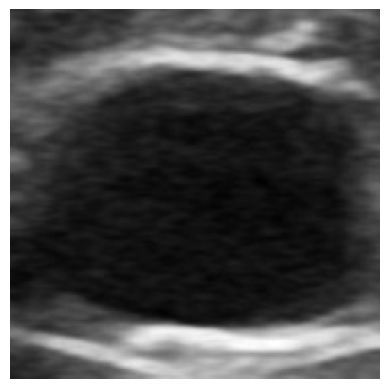

In [ ]:
def plot_sample(image):
    plt.imshow(np.transpose(image,(1,2,0)), cmap="gray" )
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(datatrain))
print(f'La imagen muestreada representa un: {classes[datatrain.dataset[rnd_sample_idx][1]]}')
image = datatrain.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
print(image.shape)
plot_sample(image)

In [ ]:
layer_conv = lambda x, y: nn.Conv2d(in_channels=x, out_channels=y, kernel_size=3, padding=1)

def save_checkpoint(states, checkpoint_dir, filename):
    torch.save(states, os.path.join(checkpoint_dir, filename))

def generate_plot(metrics, img_folder, graphic, epoch_end=-1, xlabel="Epoch", ylabel="Score", marker_style="o", line_style="-", grid_alpha=0.5):
    fig, ax = plt.subplots(figsize=(10, 5))

    for metric_name, metric_values in metrics.items():
        plt.plot(
            metric_values[:epoch_end],
            label=metric_name.capitalize(),
            #marker=marker_style,
            ms=2,
        )
    plt.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(color="gray", linestyle=line_style, linewidth=0.3, alpha=grid_alpha)
    plt.savefig(img_folder + graphic + ".jpg", bbox_inches="tight")
    plt.show()
    plt.close()

def graph_model(model, input_size=(32,1,128,128)):
  #print(model)
  graphviz.set_jupyter_format('png')

  model_graph = draw_graph(model_ss, input_size=(32,1,128,128), expand_nested=True)
  model_graph.visual_graph

def weights_init(m):
      classname = m.__class__.__name__
      if classname.find("Conv") != -1:
          nn.init.normal_(m.weight.data, 0.0, 0.02)
      elif classname.find("BatchNorm") != -1:
          nn.init.normal_(m.weight.data, 1.0, 0.02)
          nn.init.constant_(m.bias.data, 0)

def decorador(f):
	def la_funcion(*args, **kwargs):
		print("_____________________")
		return f(*args, **kwargs)
	return la_funcion



@decorador
def stats_model(name_model, model_net, epoch_state):
  try:
    net_test = model_net
    checkpoint = torch.load(checkpoints_dir + 'chckp' +str(epoch_state) +'.pth')
    net_test.load_state_dict(checkpoint['classifier_state'])
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    predictions_ext = []
    labels_ext = []
    s = ""
    # again no gradients needed
    with torch.no_grad():
        for data in datatest:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model_net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            predictions_ext.append(predictions.tolist())
            labels_ext.append(labels.tolist())
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    real_labels = [element for nestedlist in labels_ext for element in nestedlist]
    model_predictions = [element for nestedlist in predictions_ext for element in nestedlist]
    cm = confusion_matrix(real_labels, model_predictions)

    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        s = s + ('Accuracy for %s: %.1f %%\n' % (classname, accuracy))
    # print final stats
    print(name_model, ' - ', epoch_state)
    print(s)
    print(cm)
    print(classification_report(real_labels, model_predictions, target_names=classes, output_dict=False))
  except Exception as inst:
    print('ERROR EPOCA: ', x, ' ',inst)

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            num_correct += (pred == yi).sum()
            num_total += pred.size(0)
        return float(num_correct)/num_total

def train(model, optimizer, num_epochs, parm_list, checkpoint_dir="checkpoints"):
    filename = 'chckp'
    aux_acc = 0
    save = ""
    for epoch in range(num_epochs):
        for i, (xi, yi) in enumerate(datatrain):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
           # evaluate(model_tl)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        acc = accuracy(model, datatest)


        print('%d| costo: %.2f - precisión: %.2f %s' % (epoch, cost, acc, save))

In [ ]:
metrics = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}
costs = {'loss': []}

def train_plus(model, optimizer, num_epochs, parm_list, checkpoint_dir="checkpoints"):
    filename = 'chckp'
    aux_acc = 0
    save = ""

    # Initialize lists to store metrics
    global metrics, costs
    metrics = {'precision': [], 'recall': [], 'f1': [], 'accuracy': []}
    costs = {'loss': []}

    for epoch in range(num_epochs):
        # Train
        model.train()
        for i, (xi, yi) in enumerate(datatrain):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            cost = F.cross_entropy(input= scores, target=yi)
            optimizer.zero_grad()
            cost.backward()
            optimizer.step()
        #acc = accuracy(model, datatest)
        costs['loss'].append(cost.item())

        # Evaluate
        model.eval()
        total = 0
        correct = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for xi, yi in datatest:
                xi = xi.to(device=device, dtype=torch.float32)
                yi = yi.to(device=device, dtype=torch.long)
                outputs = model(xi)
                labels = yi
                loss =  F.cross_entropy(outputs, labels)

                _, predicted = torch.max(outputs.data, 1)
                total += yi.size(0)
                correct += (predicted == yi).sum().item()

                y_true.extend(yi.tolist())
                y_pred.extend(predicted.tolist())

        accuracys = correct / total
        metrics['precision'].append(precision_score(y_true, y_pred, average='weighted'))
        metrics['recall'].append(recall_score(y_true, y_pred, average='weighted'))
        metrics['f1'].append(f1_score(y_true, y_pred, average='weighted'))
        metrics['accuracy'].append(accuracy_score(y_true, y_pred))
        print('%d| LOSS: %.2f - ACC: %.2f - PRE: %.2f - F1: %.2f - RC: %.2f %s'
              % (epoch, cost, metrics["accuracy"][-1], metrics["precision"][-1], metrics["recall"][-1], metrics["f1"][-1], save))

        # Save
        if round(metrics["accuracy"][-1], 2) > round(aux_acc, 2) or  round( metrics["accuracy"][-1], 2) == round(aux_acc, 2) or  round( metrics["accuracy"][-1], 2) >= 0.80:#:#
          save_checkpoint({
            'epoch': epoch,
            'classifier_state': model.state_dict(),
            'act_porc':  metrics["accuracy"][-1],
            'parameters': parm_list,
          }, checkpoint_dir, filename+str(epoch)+'.pth')
          save = "- Guardado"
          aux_acc = round( metrics["accuracy"][-1], 2)
        else:
          save = ""

In [ ]:
"""
class capas_cnn_1(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel,
                               out_channels=channel1,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=channel1,
                               out_channels=channel2,
                               kernel_size=3,
                               padding=1)
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features=64*64*channel2, out_features=10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.leaky_relu(self.conv2(F.leaky_relu(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

model_1 = capas_cnn_1(1, channel1, channel2)
optimizer = torch.optim.Adam(model_1.parameters(), lr)
print(model_1)
train(model_1, optimizer, epochs, "checkpoint_model1.pth")
"""
"""
class capas_cnn_2(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()

        self.conv1 = layer_conv(in_channel, channel1)
        self.bn1 = nn.BatchNorm2d(channel1)
        #nn.LeakyLeakyReLU(0.2, inplace=True)
        self.conv2 = layer_conv(channel1, channel2)
        self.bn2 = nn.BatchNorm2d(channel2)
        #nn.LeakyLeakyReLU(0.2, inplace=True)
        self.max_pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(in_features=64*64*channel2, out_features=10)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = F.leaky_relu(self.bn2(self.conv2(F.leaky_relu(self.bn1(self.conv1(x))))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

model_2 = capas_cnn_2(1, channel1, channel2)
model_2.apply(weights_init)
optimizer = torch.optim.Adam(model_2.parameters(), lr)
print(model_2)
train(model_2, optimizer, epochs, "checkpoint_model2.pth")
"""
"""
class capas_cnn_3(nn.Module):
    def __init__(self, in_channel, channel1, channel2):
        super().__init__()
        self.conv1 = layer_conv(512, 1024)
        self.bn1 = nn.BatchNorm2d(1024)
        #nn.LeakyReLU(0.2, inplace=True)
        self.max_pool = nn.MaxPool2d(2,2)
        #self.fc = nn.Linear(in_features=64*64*channel2, out_features=10)
        #self.flatten = nn.Flatten()
    def forward(self, x):
        #x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))
        x = F.leaky_relu(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.max_pool(x)
        x = self.flatten(x)
        return self.fc(x)

#model_3 = capas_cnn_3(1, channel1, channel2)
#model_3.apply(weights_init)
"""

'\nclass capas_cnn_3(nn.Module):\n    def __init__(self, in_channel, channel1, channel2):\n        super().__init__()\n        self.conv1 = layer_conv(512, 1024)\n        self.bn1 = nn.BatchNorm2d(1024)\n        #nn.LeakyReLU(0.2, inplace=True)\n        self.max_pool = nn.MaxPool2d(2,2)\n        #self.fc = nn.Linear(in_features=64*64*channel2, out_features=10)\n        #self.flatten = nn.Flatten()\n    def forward(self, x):\n        #x = F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x))))))\n        x = F.leaky_relu(F.leaky_relu(self.bn1(self.conv1(x))))\n        x = self.max_pool(x)\n        x = self.flatten(x)\n        return self.fc(x)\n\n#model_3 = capas_cnn_3(1, channel1, channel2)\n#model_3.apply(weights_init)\n'

In [ ]:
# RESNET 18
if model_name == 'R18':
  model_resnet = models.resnet18(pretrained=True)
  model_aux = nn.Sequential(*list(model_resnet.children())[1:-1])
  model_tl = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
    model_aux,
    layer_conv(512, 1024),
    nn.BatchNorm2d(1024),
    #nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=10, bias=True )
  )

# RESNET 50
if model_name == 'R50':
  model_resnet = models.resnet50(pretrained=True)
  model_aux = nn.Sequential(*list(model_resnet.children())[1:-1])
  model_tl = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
    model_aux,
    layer_conv(2048, 2048),
    nn.BatchNorm2d(2048),
    #nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Linear(in_features=2048, out_features=1000, bias=True )
  )
model_tl = model_tl.to(device=device)
optimizer = torch.optim.Adam(model_tl.parameters(), lr, betas=(beta1, beta2))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


In [ ]:
class ClassNet(nn.Module):
    def __init__(self, model_aux):
        super(ClassNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model_aux = model_aux
        self.layer_conv = layer_conv(512, 1024)
        self.batch_norm = nn.BatchNorm2d(1024)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=1024, out_features=10, bias=True )

    def forward(self, x):
        x = self.conv1(x)
        x = self.model_aux(x)
        x = self.layer_conv(x)
        x = self.batch_norm(x)
        x = self.flatten(x)
        return self.fc(x)

In [ ]:
# Crear una instancia de la clase
model_ss = ClassNet(model_aux)
graph_model(model_ss)

In [ ]:
os.makedirs(checkpoints_dir, exist_ok=True)
parm_list = (beta1, beta2, batch_size, lr, num_epochs, image_size)
#create_savelog("R", img_folder, parm_list)

train_plus(model_tl, optimizer, 100, parm_list)

0| LOSS: 0.00 - ACC: 0.92 - PRE: 0.92 - F1: 0.92 - RC: 0.92 
1| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
2| LOSS: 0.00 - ACC: 0.92 - PRE: 0.92 - F1: 0.92 - RC: 0.92 - Guardado
3| LOSS: 0.00 - ACC: 0.90 - PRE: 0.90 - F1: 0.90 - RC: 0.90 - Guardado
4| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
5| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
6| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
7| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
8| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
9| LOSS: 0.00 - ACC: 0.92 - PRE: 0.92 - F1: 0.92 - RC: 0.92 - Guardado
10| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
11| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
12| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
13| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
14| LOSS: 0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


91| LOSS: 0.30 - ACC: 0.88 - PRE: 0.89 - F1: 0.88 - RC: 0.88 - Guardado


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


92| LOSS: 0.02 - ACC: 0.88 - PRE: 0.88 - F1: 0.88 - RC: 0.88 - Guardado
93| LOSS: 0.14 - ACC: 0.92 - PRE: 0.92 - F1: 0.92 - RC: 0.92 - Guardado
94| LOSS: 0.02 - ACC: 0.88 - PRE: 0.88 - F1: 0.88 - RC: 0.88 - Guardado
95| LOSS: 0.01 - ACC: 0.88 - PRE: 0.88 - F1: 0.88 - RC: 0.88 - Guardado
96| LOSS: 0.00 - ACC: 0.88 - PRE: 0.88 - F1: 0.88 - RC: 0.88 - Guardado
97| LOSS: 0.00 - ACC: 0.89 - PRE: 0.90 - F1: 0.89 - RC: 0.89 - Guardado
98| LOSS: 0.00 - ACC: 0.91 - PRE: 0.91 - F1: 0.91 - RC: 0.91 - Guardado
99| LOSS: 0.00 - ACC: 0.89 - PRE: 0.89 - F1: 0.89 - RC: 0.89 - Guardado


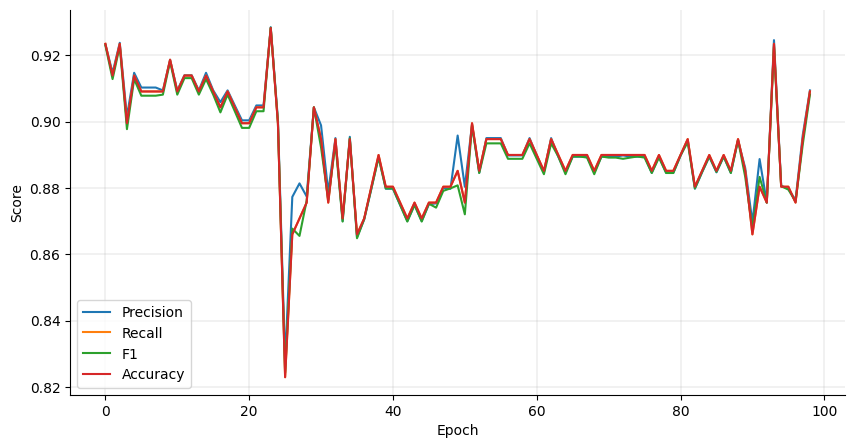

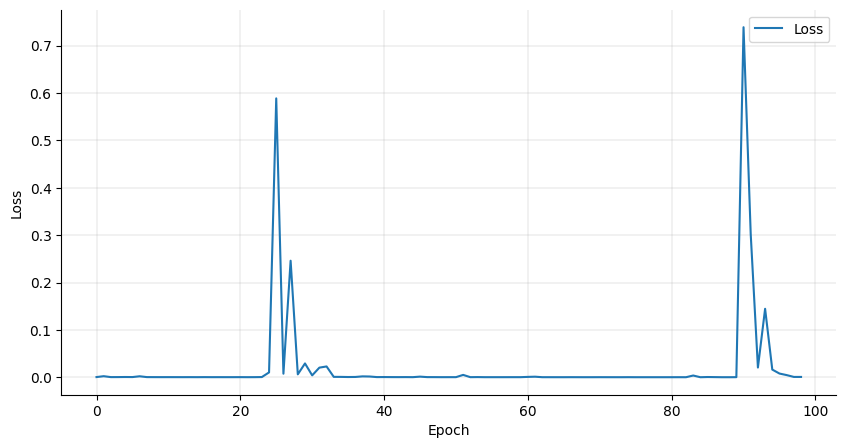

In [ ]:
 generate_plot(metrics, img_folder='path_to_your_folder', graphic='name_of_your_graphic')
 generate_plot(costs, img_folder='path_to_your_folder', graphic='name_of_your_graphic', ylabel="Loss")

In [ ]:
#@title Evaluar checkpoint
evaluate_list = [ x for x in range(0,99)]
#evaluate_list = evaluate_list[4:]

for x in evaluate_list:
    stats_model(model_name, model_tl, x)

_____________________
R18  -  0
Accuracy for benign: 95.4 %
Accuracy for malignant: 87.2 %

[[125   6]
 [ 10  68]]
              precision    recall  f1-score   support

      benign       0.93      0.95      0.94       131
   malignant       0.92      0.87      0.89        78

    accuracy                           0.92       209
   macro avg       0.92      0.91      0.92       209
weighted avg       0.92      0.92      0.92       209

_____________________
R18  -  1
Accuracy for benign: 96.2 %
Accuracy for malignant: 83.3 %

[[126   5]
 [ 13  65]]
              precision    recall  f1-score   support

      benign       0.91      0.96      0.93       131
   malignant       0.93      0.83      0.88        78

    accuracy                           0.91       209
   macro avg       0.92      0.90      0.91       209
weighted avg       0.91      0.91      0.91       209

_____________________
R18  -  2
Accuracy for benign: 96.2 %
Accuracy for malignant: 85.9 %

[[126   5]
 [ 11  67]]
 